In [107]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from modshogun import *

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

In [2]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, mortality_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

# query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

32290


,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,0,0,0,0,70.826046,0,5,0,62.0,119.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
32286,0,0,0,0,63.893494,0,2,1,60.0,95.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
32287,0,0,0,0,43.594414,0,0,1,58.0,80.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32288,1,1,1,1,86.957864,1,2,1,52.0,68.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
32289,0,0,0,0,77.488270,1,0,1,28.0,74.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


## Principal Component Analysis

In [108]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 22603)
('Number of testing samples:', 9687)


In [109]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

In [110]:
preprocessor = PCA(AUTO)

preprocessor.set_target_dim(48)

preprocessor.init(X_train)

E = preprocessor.get_transformation_matrix()
mean = preprocessor.get_mean()

#Get all the eigenvalues returned by PCA.
eig_value = preprocessor.get_eigenvalues()

print(eig_value)

X_transformed = preprocessor.apply_to_feature_matrix(X_train).T

print(X_transformed[:, 0])

[ 0.01518624  0.02105273  0.04639135  0.05442586  0.0594758   0.06029003
  0.09052768  0.12873543  0.13550631  0.21896065  0.22534858  0.22726647
  0.25028809  0.27740557  0.32681767  0.35340083  0.36384161  0.42265185
  0.4401412   0.44916387  0.47917281  0.51201246  0.57479038  0.63759838
  0.66896667  0.70007504  0.78275744  0.78933194  0.84620183  0.87661971
  0.90882884  0.95284362  0.99164835  1.01047059  1.18407776  1.26703612
  1.32142152  1.39900352  1.5517613   1.70586037  1.80320696  2.16376457
  2.41615497  2.60386819  2.71934855  3.6816201   4.34371495  4.94308891]
[ 0.01688562 -0.17268246  0.04270941 ...,  0.00933425  0.02306006
  0.0579221 ]


In [63]:
preprocessor = PCA(AUTO)

preprocessor.set_target_dim(2)

preprocessor.init(X_train)

E = preprocessor.get_transformation_matrix()
mean = preprocessor.get_mean()

#Get all the eigenvalues returned by PCA.
eig_value = preprocessor.get_eigenvalues()

print(eig_value)

X_transformed = preprocessor.apply_to_feature_matrix(X_train).T

print(X_transformed[0, :])

[ 0.01518624  0.02105273  0.04639135  0.05442586  0.0594758   0.06029003
  0.09052768  0.12873543  0.13550631  0.21896065  0.22534858  0.22726647
  0.25028809  0.27740557  0.32681767  0.35340083  0.36384161  0.42265185
  0.4401412   0.44916387  0.47917281  0.51201246  0.57479038  0.63759838
  0.66896667  0.70007504  0.78275744  0.78933194  0.84620183  0.87661971
  0.90882884  0.95284362  0.99164835  1.01047059  1.18407776  1.26703612
  1.32142152  1.39900352  1.5517613   1.70586037  1.80320696  2.16376457
  2.41615497  2.60386819  2.71934855  3.6816201   4.34371495  4.94308891]
[ 1.40228229 -0.87036092]


## 2D representation using PCA

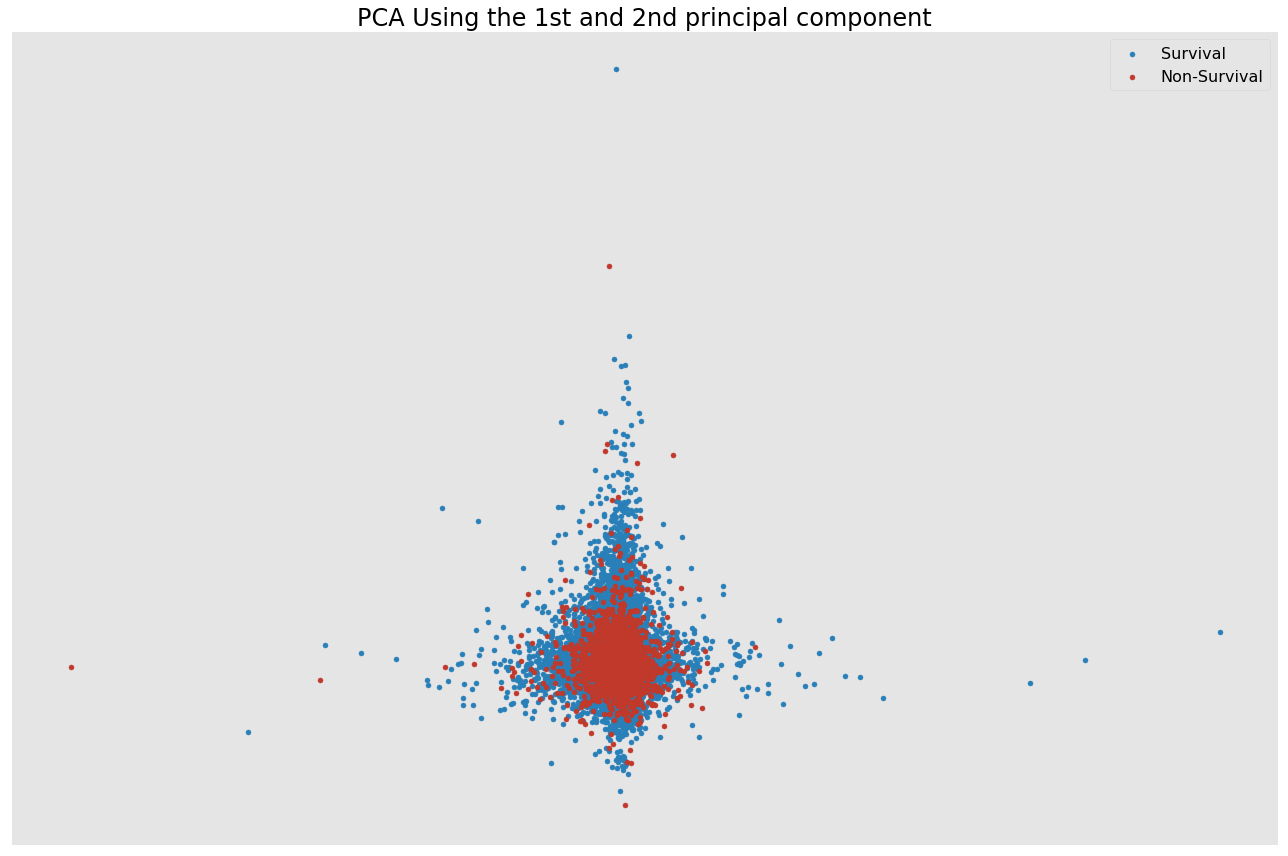

In [113]:
fig, plot = plt.subplots(figsize=(18, 12))
#fig.set_size_inches(25, 25)
plt.prism()

# X_transformed = preprocessor.apply_to_feature_matrix(X_train).T # this crashes when ran twice
colors = [
    ('#2980b9', 'o'), # blue
    ('#c0392b', 'o'), # red

]

labels = np.unique(y_train.get_labels())

for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]],
    [X_transformed[:,1][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]], 25,
    label=['Survival', 'Non-Survival'][num], color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1, fontsize=16)
plt.title("PCA Using the 1st and 2nd principal component", fontsize=24)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

## Retained variance vs performance

In [82]:
X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

preprocessor = PCA(AUTO)
preprocessor.set_target_dim(48)
preprocessor.init(X_train)
X_transformed = preprocessor.apply_to_feature_matrix(X_train)
X_test_transformed = preprocessor.apply_to_feature_matrix(X_test)

n_components = [2, 4, 8, 10, 16, 20, 24, 32, 40, 44, 48]
rm = []
aucs = []
eigen_sum = sum(eig_value)

# Parameters to svm
C = 0.1
epsilon = 0.001

for component in n_components:
    
    X_train = X_transformed[:component, :]
    X_test = X_test_transformed[:component, :]

    X_train = RealFeatures(X_train)
    X_test = RealFeatures(X_test)
    
    lr = LibLinear(C, X_train, y_train)
    lr.set_liblinear_solver_type(L2R_LR)
    lr.set_epsilon(epsilon)

    lr.train()

    y_pred = lr.apply(X_test)

    lr_roc = ROCEvaluation()
    lr_roc.evaluate(y_pred, y_test)

    auc = lr_roc.get_auROC()
    print("Area under ROC(%):", auc, " (components: %d)" % component)    
        
    aucs.append(auc)
    
    retained_variance = sum(eig_value[:component]) / eigen_sum
    
    rm.append(retained_variance)

('Area under ROC(%):', 0.5126518085701792)
('Area under ROC(%):', 0.539211559619722)
('Area under ROC(%):', 0.5526297771195736)
('Area under ROC(%):', 0.5486884058312623)
('Area under ROC(%):', 0.5664400664400573)
('Area under ROC(%):', 0.5698240290077)
('Area under ROC(%):', 0.6002738553758937)
('Area under ROC(%):', 0.6438200927996828)
('Area under ROC(%):', 0.7111868540440038)
('Area under ROC(%):', 0.764618172781434)
('Area under ROC(%):', 0.8467379691869136)


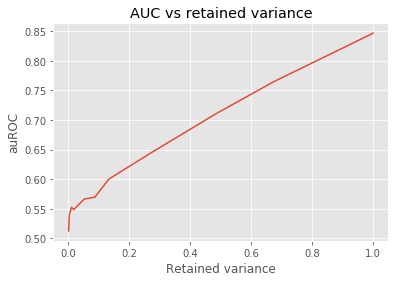

In [87]:
plt.plot(rm, aucs)
plt.xlabel("Retained variance")
plt.ylabel("auROC")

plt.title("AUC vs retained variance")

In [130]:
pca.explained_variance_ratio_

array([  9.80440888e-01,   1.12505679e-02,   5.06214525e-03,
         6.92098579e-04,   5.52926838e-04,   4.56820724e-04,
         3.68897773e-04,   2.70343234e-04,   2.16623296e-04,
         1.52020370e-04,   9.93264358e-05,   7.83245555e-05,
         6.62649269e-05,   5.03797751e-05,   4.09374163e-05,
         3.88781998e-05,   2.93142935e-05,   2.73748145e-05,
         1.85344889e-05,   1.81038763e-05,   1.74536766e-05,
         9.47761770e-06,   8.00780830e-06,   5.74812143e-06,
         5.00370831e-06,   4.16926627e-06,   3.88402868e-06,
         3.59459848e-06,   2.12244369e-06,   1.88796676e-06,
         1.76668189e-06,   1.13721852e-06,   8.68505610e-07,
         7.57122237e-07,   6.81285356e-07,   5.83724513e-07,
         4.64885500e-07,   3.50366906e-07,   3.09205864e-07,
         1.82441066e-07,   1.71995728e-07,   1.60835595e-07,
         1.18213811e-07,   1.04622111e-07,   7.92042035e-08,
         6.98975461e-08,   5.10234347e-08,   2.27336266e-08])

22132.1041667


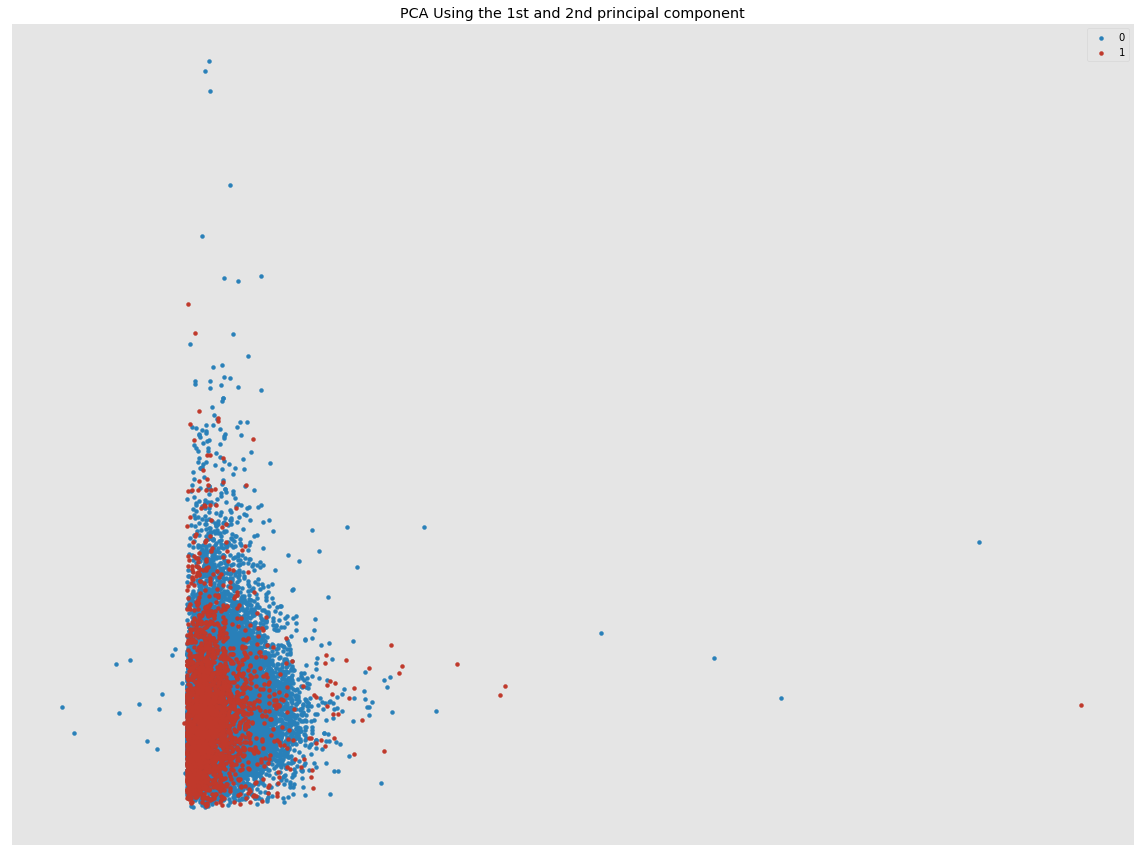

In [117]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)
print(pca.explained_variance_.sum())

X_train = np.array(X[:split])
X_test = np.array(X[split:])

y_train = np.array(y[:split])
y_test = np.array(y[split:])

fig, plot = plt.subplots(figsize=(16, 12))
#fig.set_size_inches(25, 25)
plt.prism()

X_transformed = pca.fit_transform(X_train)

# X_transformed = preprocessor.apply_to_feature_matrix(X_train).T # this crashes when ran twice
colors = [
    ('#2980b9', 'o'), # blue
    ('#c0392b', 'o'), # red

]

labels = np.unique(y_train)

for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == labels[num]],
    [X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == labels[num]], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plt.title("PCA Using the 1st and 2nd principal component")
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()


In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_components = [2, 4, 8, 10, 16, 20, 24, 32, 40, 44, 48]
rm = []
aucs = []

for component in n_components:
    X_train = X_transformed[:, :component]
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    y_score = lr.predict_proba(X_train)
    
    auc = roc_auc_score(y_train, y_score[:, 1])
    aucs.append(auc)
    rm.append(pca.explained_variance_ratio_[:component].sum())

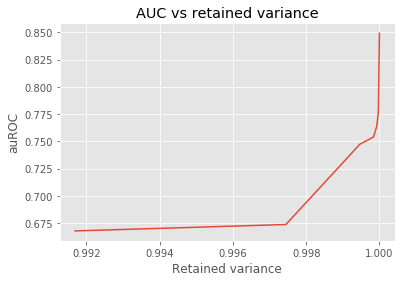

In [138]:
plt.plot(rm, aucs)
plt.xlabel("Retained variance")
plt.ylabel("auROC")

plt.title("AUC vs retained variance")

In [137]:
aucs

[0.66794277002739555,
 0.67380158295584647,
 0.73378618291007569,
 0.74733094056032989,
 0.75394395496920164,
 0.76420877770136109,
 0.77698252323698935,
 0.8346041895585331,
 0.84408081333214369,
 0.84805406315800802,
 0.84908050187009887]

## Feature Selection

In [29]:
lda = LDA()
lda.get_